<a href="https://colab.research.google.com/github/rbarman/AnimeGANs/blob/master/Anime_face_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Inspiration from https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html

In [1]:
from IPython.display import Image as display_image
from google.colab import drive
import os
import random
import PIL
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision.transforms as T
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid, save_image
from tqdm.notebook import tqdm
%matplotlib inline

In [2]:
!git clone https://github.com/rbarman/AnimeGANs

Cloning into 'AnimeGANs'...
remote: Enumerating objects: 75, done.
remote: Counting objects: 100% (75/75), done.
remote: Compressing objects: 100% (64/64), done.
remote: Total 75 (delta 34), reused 24 (delta 9), pack-reused 0
Unpacking objects: 100% (75/75), done.


In [3]:
%cd AnimeGANs/

/content/AnimeGANs


In [4]:
!ls

Anime_face_GAN.ipynb  Face_Inference.ipynb  README.md
device_utils.py       my_modules.py	    train_utils.py


In [5]:
from my_modules import Discriminator, Generator
from device_utils import get_default_device, DeviceDataLoader, to_device
from train_utils import GANTrainer

**Get images**
- I saved results from https://github.com/bchao1/Anime-Face-Dataset to google drive
- Could get more samples using the haar cascade from https://github.com/nagadomi/animeface-2009

In [6]:
%%capture
drive.mount('/content/drive')
!tar -xvzf  /content/drive/My\ Drive/Anime-Faces.tgz

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········


In [7]:
def view_rand_img(img_dir = '/content/AnimeGANs/cropped/'):
  imgs = os.listdir(img_dir)
  img_path = img_dir  + random.choice(imgs)
  print(img_path)
  return display_image(img_path)

/content/AnimeGANs/cropped/6531_2003.jpg


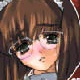

In [8]:
view_rand_img()

In [9]:
# There are some invalid images...
display_image('/content/AnimeGANs/cropped/44478_2013.jpg')

In [10]:
for img_name in os.listdir('/content/AnimeGANs/cropped/'):
  img_path = f'/content/AnimeGANs/cropped/{img_name}'
  try:
    _ = PIL.Image.open(img_path)
  except PIL.UnidentifiedImageError:
    #print(f'{img_path} is an invalid image')
    os.remove(img_path)

Create DataLoaders

In [11]:
ROOT_IMAGE_DIR = '/content/'
IMAGE_SIZE = 64
BATCH_SIZE = 128
LATENT_SIZE = 100
NUM_CHANNELS = 3
STATS = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

In [12]:
train_ds = ImageFolder(ROOT_IMAGE_DIR, transform=T.Compose([
    T.Resize(IMAGE_SIZE),
    T.CenterCrop(IMAGE_SIZE),
    T.RandomHorizontalFlip(),
    T.ToTensor(),
    T.Normalize(*STATS)]))

In [13]:
train_dl = DataLoader(train_ds, BATCH_SIZE, shuffle=True, num_workers=3)

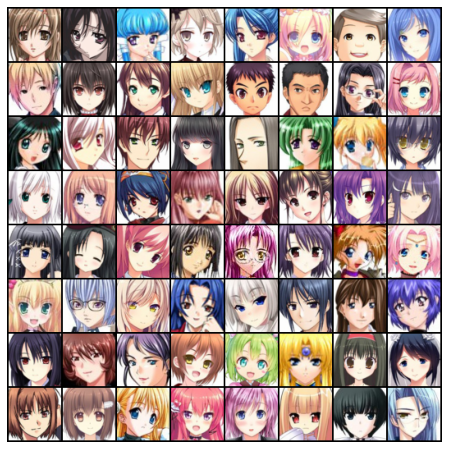

In [14]:
def show_batch(dl):
  images, _ = next(iter(dl))
  plt.figure(figsize=(8,8))
  plt.axis("off")
  # permuting because matplotlib needs (x,y, num channels) while tensor is (num channels, x, y)
  plt.imshow(make_grid(images.detach()[0:64],padding=2,normalize=True,).permute(1,2,0));

show_batch(train_dl)

In [15]:
device = get_default_device()
device

device(type='cuda')

In [16]:
train_dl = DeviceDataLoader(train_dl, device)

In [ ]:
images,labels = next(iter(train_dl))
images.shape, labels.shape

(torch.Size([128, 3, 64, 64]), torch.Size([128]))

Confirm shapes with Discriminator and Generator

In [ ]:
# Discriminator classifies if an image is real or not
  # input is a batch of images
  # output is a batch of results
discriminator = Discriminator(num_features = 64)
discriminator = to_device(discriminator, device)
images,labels = next(iter(train_dl))

print(f'INPUT: ',images.shape)
out = discriminator(images)
print('OUTPUT: ',out.shape)

INPUT:  torch.Size([128, 3, 64, 64])
OUTPUT:  torch.Size([128, 1])


In [ ]:
# Generator takes a vector of noise and creates images
  # input is batch of noise/random 
  # output is a batch of images
generator = Generator(latent_vector_len = LATENT_SIZE,num_features = 64)
generator = to_device(generator, device)
noise = torch.randn(BATCH_SIZE, LATENT_SIZE, 1, 1, device=device)
print(f'INPUT: ',noise.shape)
out = generator(noise)
print('OUTPUT: ',out.shape)

INPUT:  torch.Size([128, 100, 1, 1])
OUTPUT:  torch.Size([128, 3, 64, 64])


Training Loop

In [ ]:
'''
pseudo code of training loop:

for epoch in epochs:
  for batch in train dataloader:
    
    # Train Discriminator
    - forward pass of {real} images to Discriminator
    - calculate loss + backwards pass

    - create batch of fake images from Generator
    - forward pass of images to Discriminator
    - calculate loss + backwards pass

    - add both gradients from both losses  + update Discriminator weights

    # Train Generator
    - foward pass of latent vector to create fake images
    - forward pass of fake images to Discriminator
    - calculate loss (how well the discrimator classifies the images are fake)
    - backwards pass + update weights
'''

'\npseudo code of training loop:\n\nfor epoch in epochs:\n  for batch in train dataloader:\n    \n    # Train Discriminator\n    - forward pass of {real} images to Discriminator\n    - calculate loss + backwards pass\n\n    - create batch of fake images from Generator\n    - forward pass of images to Discriminator\n    - calculate loss + backwards pass\n\n    - add both gradients from both losses  + update Discriminator weights\n\n    # Train Generator\n    - foward pass of latent vector to create fake images\n    - forward pass of fake images to Discriminator\n    - calculate loss (how well the discrimator classifies the images are fake)\n    - backwards pass + update weights\n'

In [17]:
gan = GANTrainer(train_dl)
history = gan.train(num_epochs = 10)

Saving training session data to /content/drive/My Drive/AnimeGANs/07222020_034538/



Saving to /content/drive/My Drive/AnimeGANs/07222020_034538/generated/1.png
Epoch [1/10], loss_g: 4.5301, loss_d: 0.5608, real_score: 0.9342, fake_score: 0.3222



Saving to /content/drive/My Drive/AnimeGANs/07222020_034538/generated/2.png
Epoch [2/10], loss_g: 4.4832, loss_d: 0.2830, real_score: 0.9280, fake_score: 0.1725



Saving to /content/drive/My Drive/AnimeGANs/07222020_034538/generated/3.png
Epoch [3/10], loss_g: 9.3829, loss_d: 0.5818, real_score: 0.6342, fake_score: 0.0004



Saving to /content/drive/My Drive/AnimeGANs/07222020_034538/generated/4.png
Epoch [4/10], loss_g: 5.5204, loss_d: 0.2360, real_score: 0.9115, fake_score: 0.1229



Saving to /content/drive/My Drive/AnimeGANs/07222020_034538/generated/5.png
Epoch [5/10], loss_g: 4.5842, loss_d: 0.9046, real_score: 0.5102, fake_score: 0.0006



Saving to /content/drive/My Drive/AnimeGANs/07222020_034538/generated/6.png
Epoch [6/10], loss_g: 4.4801, loss_d: 0.2223, real_score: 0.8965, fake_score: 0.0903



Saving to /content/drive/My Drive/AnimeGANs/07222020_034538/generated/7.png
Epoch [7/10], loss_g: 5.3458, loss_d: 0.2352, real_score: 0.9569, fake_score: 0.1582



Saving to /content/drive/My Drive/AnimeGANs/07222020_034538/generated/8.png
Epoch [8/10], loss_g: 3.4681, loss_d: 0.1313, real_score: 0.9492, fake_score: 0.0669



Saving to /content/drive/My Drive/AnimeGANs/07222020_034538/generated/9.png
Epoch [9/10], loss_g: 4.4006, loss_d: 0.4578, real_score: 0.6951, fake_score: 0.0091



Saving to /content/drive/My Drive/AnimeGANs/07222020_034538/generated/10.png
Epoch [10/10], loss_g: 5.7754, loss_d: 0.0796, real_score: 0.9709, fake_score: 0.0451


Results per epoch

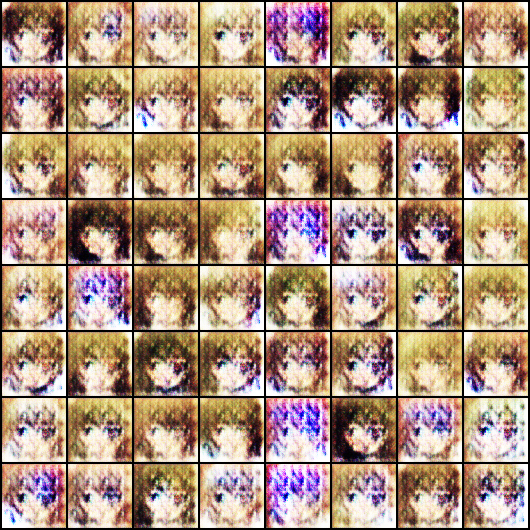

In [19]:
display_image('/content/drive/My Drive/AnimeGANs/07222020_034538/generated/1.png')

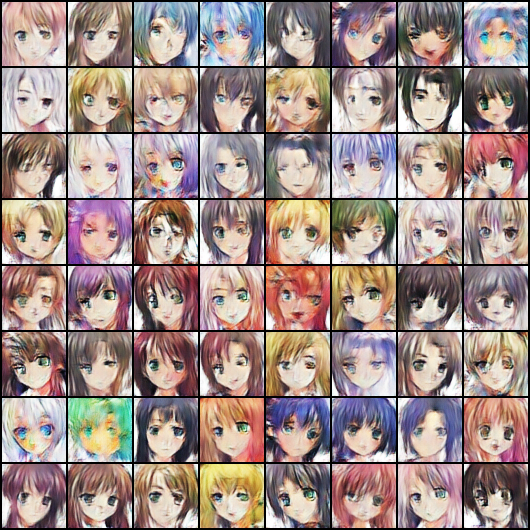

In [20]:
display_image('/content/drive/My Drive/AnimeGANs/07222020_034538/generated/10.png')

By epoch 10 we see more smoothness...

- https://pytorch.org/docs/stable/tensorboard.html
- https://colab.research.google.com/github/tensorflow/tensorboard/blob/master/docs/tensorboard_in_notebooks.ipynb#scrollTo=Po7rTfQswAMT



In [21]:
# Train for another 10 epochs...
  # TODO: GANTrainer should internally track iter_start...
  # TODO: what about tracking history?
history2 = gan.train(num_epochs = 10,iter_start=11)


Saving to /content/drive/My Drive/AnimeGANs/07222020_034538/generated/11.png
Epoch [1/10], loss_g: 4.3341, loss_d: 0.1602, real_score: 0.9137, fake_score: 0.0604



Saving to /content/drive/My Drive/AnimeGANs/07222020_034538/generated/12.png
Epoch [2/10], loss_g: 4.2228, loss_d: 0.1150, real_score: 0.9649, fake_score: 0.0703



Saving to /content/drive/My Drive/AnimeGANs/07222020_034538/generated/13.png
Epoch [3/10], loss_g: 3.8686, loss_d: 0.1105, real_score: 0.9318, fake_score: 0.0329



Saving to /content/drive/My Drive/AnimeGANs/07222020_034538/generated/14.png
Epoch [4/10], loss_g: 4.8400, loss_d: 0.1380, real_score: 0.9646, fake_score: 0.0893



Saving to /content/drive/My Drive/AnimeGANs/07222020_034538/generated/15.png
Epoch [5/10], loss_g: 3.2526, loss_d: 0.0914, real_score: 0.9639, fake_score: 0.0487



Saving to /content/drive/My Drive/AnimeGANs/07222020_034538/generated/16.png
Epoch [6/10], loss_g: 7.6351, loss_d: 0.4700, real_score: 0.9823, fake_score: 0.3166



Saving to /content/drive/My Drive/AnimeGANs/07222020_034538/generated/17.png
Epoch [7/10], loss_g: 4.1742, loss_d: 0.1320, real_score: 0.9093, fake_score: 0.0279



Saving to /content/drive/My Drive/AnimeGANs/07222020_034538/generated/18.png
Epoch [8/10], loss_g: 4.6260, loss_d: 0.1190, real_score: 0.9500, fake_score: 0.0578



Saving to /content/drive/My Drive/AnimeGANs/07222020_034538/generated/19.png
Epoch [9/10], loss_g: 3.9622, loss_d: 0.3888, real_score: 0.7194, fake_score: 0.0039



Saving to /content/drive/My Drive/AnimeGANs/07222020_034538/generated/20.png
Epoch [10/10], loss_g: 4.4846, loss_d: 0.1153, real_score: 0.9617, fake_score: 0.0680


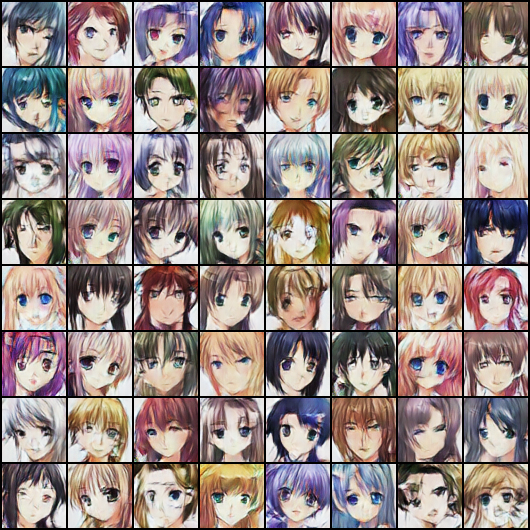

In [22]:
display_image('/content/drive/My Drive/AnimeGANs/07222020_034538/generated/20.png')

In [23]:
# save checkpoint
checkpoint_dir = f'{gan.session_folder}checkpoints/'
os.mkdir(checkpoint_dir)

In [24]:
# TODO: GANTrainer needs this as an internal func

torch.save({
            'epoch': 20,
            'discriminator_state_dict': gan.discriminator.state_dict(),
            'optimizerD_state_dict': gan.optimizerD.state_dict(),
            'generator_state_dict': gan.generator.state_dict(),
            'optimizerG_state_dict': gan.optimizerG.state_dict()
            }
           , f'{checkpoint_dir}1.pth')